In [16]:
%pylab inline
import pandas as pd
import seaborn as sns

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

Populating the interactive namespace from numpy and matplotlib


# Natural Language Processing (NLP)

*Adapted from [NLP Crash Course](http://files.meetup.com/7616132/DC-NLP-2013-09%20Charlie%20Greenbacker.pdf) by Charlie Greenbacker and [Introduction to NLP](http://spark-public.s3.amazonaws.com/nlp/slides/intro.pdf) by Dan Jurafsky*

### What is NLP?

- Using computers to process (analyze, understand, generate) natural human languages
- Most knowledge created by humans is unstructured text, and we need a way to make sense of it
- Build probabilistic model using data about a language

### What are some of the higher level task areas?

- **Information retrieval**: Find relevant results and similar results
    - [Google](https://www.google.com/)
- **Information extraction**: Structured information from unstructured documents
    - [Events from Gmail](https://support.google.com/calendar/answer/6084018?hl=en)
- **Machine translation**: One language to another
    - [Google Translate](https://translate.google.com/)
- **Text simplification**: Preserve the meaning of text, but simplify the grammar and vocabulary
    - [Rewordify](https://rewordify.com/)
    - [Simple English Wikipedia](https://simple.wikipedia.org/wiki/Main_Page)
- **Predictive text input**: Faster or easier typing
    - [My application](https://justmarkham.shinyapps.io/textprediction/)
    - [A much better application](https://farsite.shinyapps.io/swiftkey-cap/)
- **Sentiment analysis**: Attitude of speaker
    - [Hater News](http://haternews.herokuapp.com/)
- **Automatic summarization**: Extractive or abstractive summarization
    - [autotldr](https://www.reddit.com/r/technology/comments/35brc8/21_million_people_still_use_aol_dialup/cr2zzj0)
- **Natural Language Generation**: Generate text from data
    - [How a computer describes a sports match](http://www.bbc.com/news/technology-34204052)
    - [Publishers withdraw more than 120 gibberish papers](http://www.nature.com/news/publishers-withdraw-more-than-120-gibberish-papers-1.14763)
- **Speech recognition and generation**: Speech-to-text, text-to-speech
    - [Google's Web Speech API demo](https://www.google.com/intl/en/chrome/demos/speech.html)
    - [Vocalware Text-to-Speech demo](https://www.vocalware.com/index/demo)
- **Question answering**: Determine the intent of the question, match query with knowledge base, evaluate hypotheses
    - [How did supercomputer Watson beat Jeopardy champion Ken Jennings?](http://blog.ted.com/how-did-supercomputer-watson-beat-jeopardy-champion-ken-jennings-experts-discuss/)
    - [IBM's Watson Trivia Challenge](http://www.nytimes.com/interactive/2010/06/16/magazine/watson-trivia-game.html)
    - [The AI Behind Watson](http://www.aaai.org/Magazine/Watson/watson.php)

### What are some of the lower level components?

- **Tokenization**: breaking text into tokens (words, sentences, n-grams)
- **Stopword removal**: a/an/the
- **Stemming and lemmatization**: root word
- **TF-IDF**: word importance
- **Part-of-speech tagging**: noun/verb/adjective
- **Named entity recognition**: person/organization/location
- **Spelling correction**: "New Yrok City"
- **Word sense disambiguation**: "buy a mouse"
- **Segmentation**: "New York City subway"
- **Language detection**: "translate this page"
- **Machine learning**

### Why is NLP hard?

- **Ambiguity**:
    - Hospitals are Sued by 7 Foot Doctors
    - Juvenile Court to Try Shooting Defendant
    - Local High School Dropouts Cut in Half
- **Non-standard English**: text messages
- **Idioms**: "throw in the towel"
- **Newly coined words**: "retweet"
- **Tricky entity names**: "Where is A Bug's Life playing?"
- **World knowledge**: "Mary and Sue are sisters", "Mary and Sue are mothers"

NLP requires an understanding of the **language** and the **world**.

## Reading in the Yelp Reviews

- "corpus" = collection of documents
- "corpora" = plural form of corpus

In [3]:
#!pip install textblob
#!python -m textblob.download_corpora

In [17]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [36]:
# read yelp.csv into a DataFrame
url = '../data/yelp.csv'
yelp = pd.read_csv(url)

# create a new DataFrame that only contains the 5-star and 1-star reviews
yelp_best_worst = yelp[(yelp.stars==5) | (yelp.stars==1)]

# define X and y
X = yelp_best_worst.text
y = yelp_best_worst.stars

# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Tokenization

From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect **numerical feature vectors with a fixed size** rather than the **raw text documents with variable length**.

We will use [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to "convert text into a matrix of token counts":

- **What:** Separate text into units such as sentences or words
- **Why:** Gives structure to previously unstructured text
- **Notes:** Relatively easy with English language text, not easy with some languages

#### Example

In [37]:
# start with a simple example
simple_train = [
    'call you tonight',
    'Call me a cab',
    'please call me... PLEASE!'
]
# learn the 'vocabulary' of the training data
vect = CountVectorizer()
vect.fit(simple_train)
simple_train_dtm = vect.transform(simple_train)
pd.DataFrame(simple_train_dtm.toarray(), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> In this scheme, features and samples are defined as follows:

> - Each individual token occurrence frequency (normalized or not) is treated as a **feature**.
> - The vector of all the token frequencies for a given document is considered a multivariate **sample**.

> A **corpus of documents** can thus be represented by a matrix with **one row per document** and **one column per token** (e.g. word) occurring in the corpus.

> We call **vectorization** the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the **Bag of Words** or "Bag of n-grams" representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

#### Vectorizing the yelp reviews

In [49]:
# use CountVectorizer to create document-term matrices from X_train and X_test
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [50]:
# rows are documents, columns are terms (aka "tokens" or "features")
X_train_dtm.shape

(3064, 16825)

### A Multinomial Naive Bayes model for rating prediction

We will use [Multinomial Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html):

> The multinomial Naive Bayes classifier is suitable for classification with **discrete features** (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [51]:
# define a function that accepts a vectorizer
# trains a MultinomialNB, and calculates the accuracy
def tokenize_test(vect):
    X_train_dtm = vect.fit_transform(X_train)
    print('Features: ', X_train_dtm.shape[1])
    X_test_dtm = vect.transform(X_test)
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)
    print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))

In [52]:
tokenize_test(vect)

Features:  16825
Accuracy:  0.918786692759


In [54]:
# calculate null accuracy
y_test_binary = np.where(y_test==5, 1, 0)
max(y_test_binary.mean(), 1 - y_test_binary.mean())

0.81996086105675148

### Include $2$-grams

In [55]:
# include 1-grams and 2-grams
vect = CountVectorizer(ngram_range=(1, 2))
vect.fit(X_train).get_feature_names()[-25:]

['zucchini very',
 'zucchini with',
 'zuchinni',
 'zuchinni again',
 'zuchinni the',
 'zumba',
 'zumba class',
 'zumba or',
 'zumba yogalates',
 'zupa',
 'zupa flavors',
 'zuzu',
 'zuzu in',
 'zuzu is',
 'zuzu the',
 'zwiebel',
 'zwiebel kräuter',
 'zzed',
 'zzed in',
 'éclairs',
 'éclairs napoleons',
 'école',
 'école lenôtre',
 'ém',
 'ém all']

In [56]:
tokenize_test(vect)

Features:  169847
Accuracy:  0.854207436399


**Question**: Why do you think the accuracy went down after adding 2-grams?

## Stopword Removal

- **What:** Remove common words that will likely appear in any text
- **Why:** They don't tell you much about your text

In [57]:
# remove English stop words
vect = CountVectorizer(stop_words='english')
tokenize_test(vect)

Features:  16528
Accuracy:  0.915851272016


In [28]:
# set of stop words
print(vect.get_stop_words())

frozenset({'might', 'therefore', 'himself', 'their', 'detail', 'whither', 'anything', 'indeed', 'yourselves', 'ie', 'they', 'amoungst', 'thus', 'what', 'becoming', 'toward', 'anyhow', 'down', 'hasnt', 'least', 'anyone', 'inc', 'mostly', 'onto', 'seemed', 'sometimes', 'whenever', 'whereas', 'whether', 'a', 'latter', 'besides', 'your', 'six', 'show', 'thereafter', 'back', 'empty', 'very', 'through', 'own', 'neither', 'we', 'can', 'around', 'former', 'against', 'beyond', 'hereupon', 'cant', 'become', 'see', 'both', 'while', 'next', 'per', 'yours', 'of', 'thru', 'is', 'nowhere', 'several', 'off', 'done', 'well', 'yet', 'every', 'else', 'fifteen', 'fify', 'our', 'side', 'between', 'forty', 'few', 'again', 'upon', 'whom', 'ever', 'except', 'otherwise', 'latterly', 'within', 'into', 'than', 'among', 'not', 'moreover', 'somehow', 'must', 'still', 'across', 'go', 'thence', 'perhaps', 'whose', 'however', 'seem', 'became', 'twelve', 'any', 'anyway', 'has', 'herein', 'here', 'ourselves', 'this', '

## Stemming / Lemmatization

**Stemming:**

- **What:** Reduce a word to its base/stem/root form
- **Why:** Often makes sense to treat related words the same way
- **Notes:**
    - Uses a "simple" and fast rule-based approach
    - Stemmed words are usually not shown to users (used for analysis/indexing)
    - Some search engines treat words with the same stem as synonyms

In [60]:
# grab the first review
review = TextBlob(yelp_best_worst.text[0])

In [64]:
# initialize stemmer
stemmer = SnowballStemmer('english')

# stem each word
for orig, stemmed in zip(review.words, [stemmer.stem(word) for word in review.words]):
    print(orig, stemmed)

My my
wife wife
took took
me me
here here
on on
my my
birthday birthday
for for
breakfast breakfast
and and
it it
was was
excellent excel
The the
weather weather
was was
perfect perfect
which which
made made
sitting sit
outside outsid
overlooking overlook
their their
grounds ground
an an
absolute absolut
pleasure pleasur
Our our
waitress waitress
was was
excellent excel
and and
our our
food food
arrived arriv
quickly quick
on on
the the
semi-busy semi-busi
Saturday saturday
morning morn
It it
looked look
like like
the the
place place
fills fill
up up
pretty pretti
quickly quick
so so
the the
earlier earlier
you you
get get
here here
the the
better better
Do do
yourself yourself
a a
favor favor
and and
get get
their their
Bloody bloodi
Mary mari
It it
was was
phenomenal phenomen
and and
simply simpli
the the
best best
I i
've ve
ever ever
had had
I i
'm 'm
pretty pretti
sure sure
they they
only onli
use use
ingredients ingredi
from from
their their
garden garden
and and
blend blend
them

**Lemmatization**

- **What:** Derive the canonical form ('lemma') of a word
- **Why:** Can be better than stemming
- **Notes:** Uses a dictionary-based approach (slower than stemming)

In [65]:
# define a function that accepts text and returns a list of lemmas
def split_into_lemmas(text):
    text = text.lower()
    words = TextBlob(text).words
    return [word.lemmatize() for word in words]

In [68]:
# print words with lemmatized versions
for orig, stemmed in zip(review.words, split_into_lemmas(review.string)):
    print(orig, stemmed)

My my
wife wife
took took
me me
here here
on on
my my
birthday birthday
for for
breakfast breakfast
and and
it it
was wa
excellent excellent
The the
weather weather
was wa
perfect perfect
which which
made made
sitting sitting
outside outside
overlooking overlooking
their their
grounds ground
an an
absolute absolute
pleasure pleasure
Our our
waitress waitress
was wa
excellent excellent
and and
our our
food food
arrived arrived
quickly quickly
on on
the the
semi-busy semi-busy
Saturday saturday
morning morning
It it
looked looked
like like
the the
place place
fills fill
up up
pretty pretty
quickly quickly
so so
the the
earlier earlier
you you
get get
here here
the the
better better
Do do
yourself yourself
a a
favor favor
and and
get get
their their
Bloody bloody
Mary mary
It it
was wa
phenomenal phenomenal
and and
simply simply
the the
best best
I i
've 've
ever ever
had had
I i
'm 'm
pretty pretty
sure sure
they they
only only
use use
ingredients ingredient
from from
their their
garden 

In [69]:
# use split_into_lemmas as the feature extraction function (WARNING: SLOW!)
vect = CountVectorizer(analyzer=split_into_lemmas)
tokenize_test(vect)

Features:  16452
Accuracy:  0.920743639922


A marginal 0.2% improvement over no preprocessing

## Term Frequency-Inverse Document Frequency (TF-IDF)

- **What:** Computes "relative frequency" that a word appears in a document compared to its frequency across all documents
- **Why:** More useful than "term frequency" for identifying "important" words in each document (high frequency in that document, low frequency in other documents)
- **Notes:** Used for search engine scoring, text summarization, document clustering

In [70]:
# example documents
simple_train = ['call you tonight', 'Call me a cab', 'please call me... PLEASE!']

In [71]:
# Term Frequency
vect = CountVectorizer()
tf = pd.DataFrame(vect.fit_transform(simple_train).toarray(), columns=vect.get_feature_names())
tf

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


In [72]:
# Document Frequency
vect = CountVectorizer(binary=True)
df = vect.fit_transform(simple_train).toarray().sum(axis=0)
pd.DataFrame(df.reshape(1, 6), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,1,3,2,1,1,1


In [73]:
# Term Frequency-Inverse Document Frequency (simple version)
(tf/df)

,cab,call,me,please,tonight,you
0,0.0,0.333333,0.0,0.0,1.0,1.0
1,1.0,0.333333,0.5,0.0,0.0,0.0
2,0.0,0.333333,0.5,2.0,0.0,0.0


In [74]:
# TfidfVectorizer
vect = TfidfVectorizer()
pd.DataFrame(vect.fit_transform(simple_train).toarray(), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0.000000,0.385372,0.000000,0.000000,0.652491,0.652491
1,0.720333,0.425441,0.547832,0.000000,0.000000,0.000000
2,0.000000,0.266075,0.342620,0.901008,0.000000,0.000000


**More details:** [TF-IDF is about what matters](http://planspace.org/20150524-tfidf_is_about_what_matters/)

## Using TF-IDF to Summarize a Yelp Review

Reddit's autotldr uses the [SMMRY](http://smmry.com/about) algorithm, which is based on TF-IDF!

In [78]:
# create a document-term matrix using TF-IDF
vect = TfidfVectorizer(stop_words='english')
dtm = vect.fit_transform(yelp.text)
features = vect.get_feature_names()
dtm.shape

(10000, 28881)

In [79]:
def summarize():
    # choose a random review that is at least 300 characters
    review_length = 0
    while review_length < 300:
        review_id = np.random.randint(0, len(yelp))
        review_text = yelp.text[review_id]
        review_length = len(review_text)
    
    # create a dictionary of words and their TF-IDF scores
    word_scores = {}
    for word in TextBlob(review_text).words:
        word = word.lower()
        if word in features:
            word_scores[word] = dtm[review_id, features.index(word)]
    
    # print words with the top 5 TF-IDF scores
    print('TOP SCORING WORDS:')
    top_scores = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[:5]
    for word, score in top_scores:
        print(word)
    
    # print 5 random words
    print('\n' + 'RANDOM WORDS:')
    random_words = np.random.choice(list(word_scores.keys()), size=5, replace=False)
    for word in random_words:
        print(word)
    
    # print the review
    print('\n' + review_text)

In [80]:
summarize()

TOP SCORING WORDS:
margherita
biancoverde
incredible
rating
hair

RANDOM WORDS:
replace
neopolitana
lunch
flavors
america

I was extremely excited to try what is considered some of the "best pizza" in America..., finding out it was only minutes away from my new office. My expectations may have been too high. Our party of four went for a late lunch, we did not have to wait for a table. 

My fiance and I decided to try 2 pies, the margherita and the Biancoverde. The Margherita pie came out quite dry, not with the wonderful chewy crust that a great margherita should have... however, the Biancoverde, a white pizza with Ricotta and arugala, was fantastic! Incredible flavors, the extra toppings kept this pie perfectly moist and delicious, it was really quite perfect. 
Unfortunately, we had a hair in one of our pizzas, however, that's only part of the reason for the mediocre rating... 
The hair, the 1-2 star margherita, and the non-existant meat selection I can only give a 3 star rating... (I

## Sentiment Analysis

In [81]:
print(review)

My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.

Do yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I've ever had.  I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.

While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I've ever had.

Anyway, I can't wait to go back!


In [82]:
# provided by `TextBlob`
# polarity ranges from -1 (most negative) to 1 (most positive)
review.sentiment.polarity

0.40246913580246907

In [83]:
# define a function that accepts text and returns the polarity
def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [84]:
# create a new DataFrame column for sentiment (WARNING: SLOW!)
yelp['sentiment'] = yelp.text.apply(detect_sentiment)

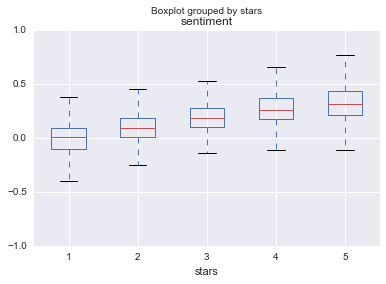

In [85]:
# box plot of sentiment grouped by stars
yelp.boxplot(column='sentiment', by='stars')
plt.show()

In [86]:
# reviews with most positive sentiment
yelp[yelp.sentiment == 1].text.head()

254    Our server Gary was awesome. Food was amazing....
347    3 syllables for this place. \nA-MAZ-ING!\n\nTh...
420                                    LOVE the food!!!!
459    Love it!!! Wish we still lived in Arizona as C...
679                                     Excellent burger
Name: text, dtype: object

In [87]:
# reviews with most negative sentiment
yelp[yelp.sentiment == -1].text.head()

773     This was absolutely horrible. I got the suprem...
1517                  Nasty workers and over priced trash
3266    Absolutely awful... these guys have NO idea wh...
4766                                       Very bad food!
5812        I wouldn't send my worst enemy to this place.
Name: text, dtype: object

In [88]:
# widen the column display
pd.set_option('max_colwidth', 500)

In [89]:
# negative sentiment in a 5-star review
yelp[(yelp.stars == 5) & (yelp.sentiment < -0.3)].head(1)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,sentiment
390,106JT5p8e8Chtd0CZpcARw,2009-08-06,KowGVoP_gygzdSu6Mt3zKQ,5,"RIP AZ Coffee Connection. :( I stopped by two days ago unaware that they had closed. I am severely bummed. This place is irreplaceable! Damn you, Starbucks and McDonalds!",review,jKeaOrPyJ-dI9SNeVqrbww,1,0,0,-0.302083


In [90]:
# positive sentiment in a 1-star review
yelp[(yelp.stars == 1) & (yelp.sentiment > 0.5)].head(1)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,sentiment
1781,53YGfwmbW73JhFiemNeyzQ,2012-06-22,Gi-4O3EhE175vujbFGDIew,1,If you like the stuck up Scottsdale vibe this is a good place for you. The food isn't impressive. Nice outdoor seating.,review,Hqgx3IdJAAaoQjvrUnbNvw,0,1,2,0.766667


In [91]:
# reset the column display width
pd.reset_option('max_colwidth')